In [3]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import open_clip
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
cross_modal_nrc_oasis_df = pd.read_csv('../results/data_NAACL/cross_modal_nrc_oasis_df_final_to_model_v1.csv')
cross_modal_old_df = pd.read_csv('../results/data_NAACL/cross_modal_old_df_final_to_model_v1.csv')

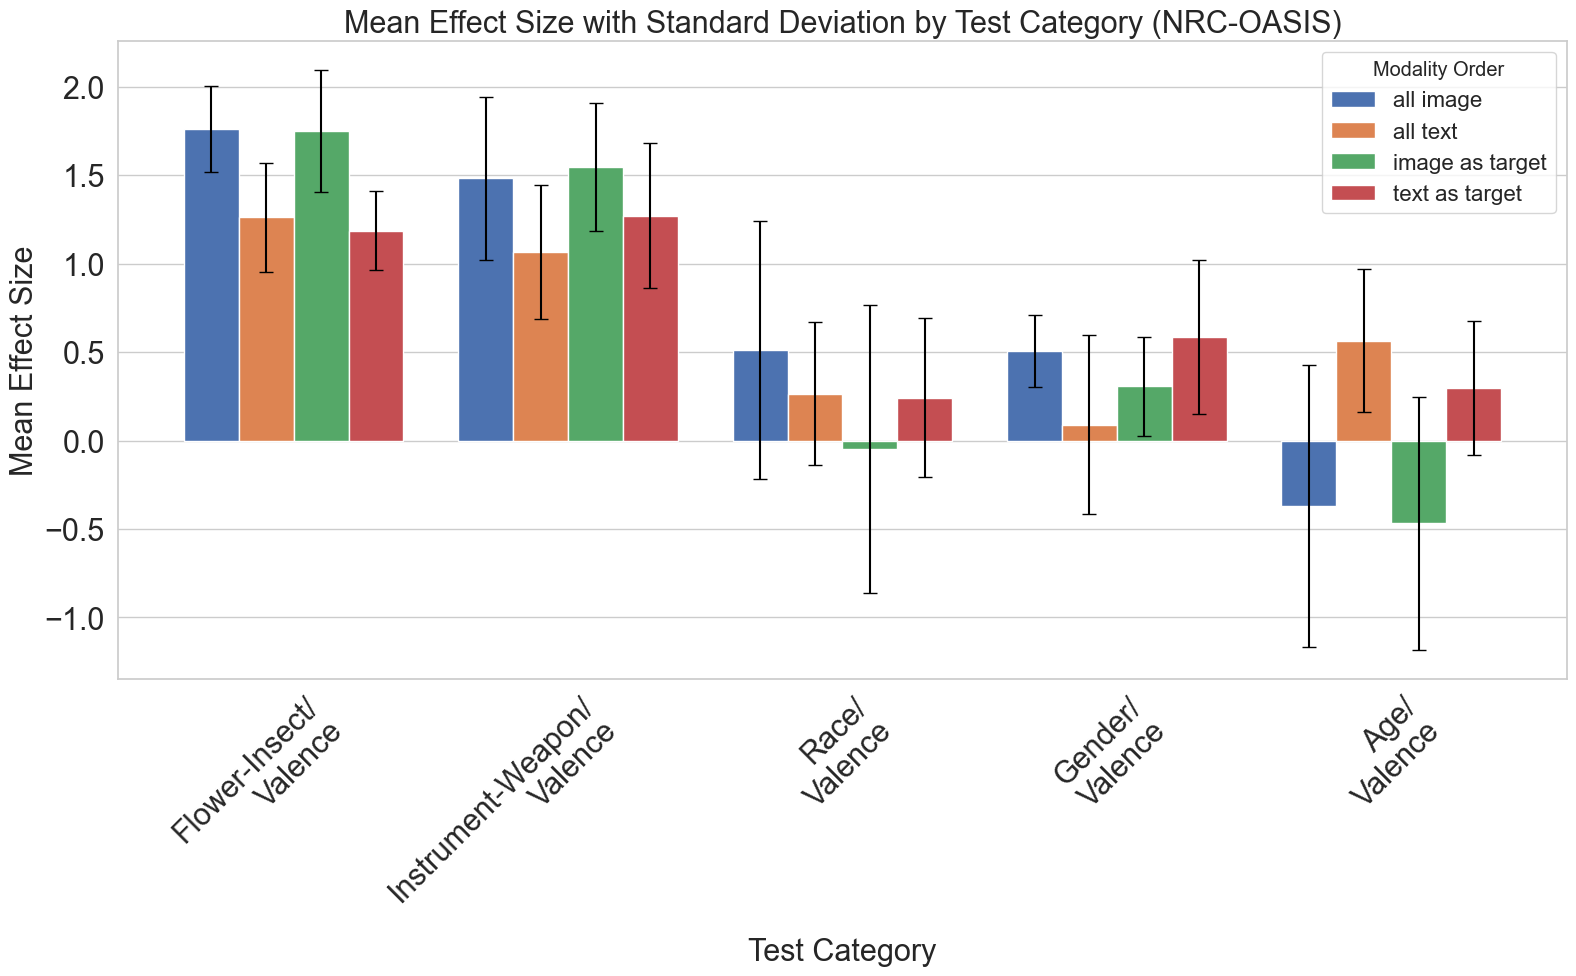

Aggregated data (means and std):
               Image Test           order  effect_size_mean  effect_size_std
              Age/Valence       all image         -0.368034         0.797127
              Age/Valence        all text          0.565038         0.402451
              Age/Valence image as target         -0.466720         0.715177
              Age/Valence  text as target          0.296866         0.378180
           Gender/Valence       all image          0.505793         0.205598
           Gender/Valence        all text          0.089977         0.507487
           Gender/Valence image as target          0.307021         0.280552
           Gender/Valence  text as target          0.585387         0.437909
    Insect-Flower/Valence       all image          1.760749         0.241257
    Insect-Flower/Valence        all text          1.261047         0.307587
    Insect-Flower/Valence image as target          1.750580         0.346759
    Insect-Flower/Valence  text as target  

In [82]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean_std_barplot(df, title, filename):
    """
    Create a grouped bar plot of mean effect sizes with standard deviation error bars.
    """

    # 1. Check for required columns
    required_cols = ['Image Test', 'order', 'effect_size']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("Required columns are missing from the DataFrame.")

    # 2. Define the desired order of categories
    category_order = [
        'Insect-Flower/Valence',
        'Instrument-Weapon/Valence', 
        'Race/Valence',
        'Gender/Valence',
        'Age/Valence'
    ]

    # Create two-line category labels
    shortened_categories = []
    for cat in category_order:
        parts = cat.split('/')
        if len(parts) > 1:
            if parts[0] == 'Insect-Flower':
                shortened_categories.append('Flower-Insect/\nValence')
            else:
                shortened_categories.append(f"{parts[0]}/\nValence")
        else:
            shortened_categories.append(cat)

    # Filter to only these categories
    df = df[df['Image Test'].isin(category_order)]

    # 3. Aggregate: compute mean and std
    means = df.groupby(['Image Test', 'order'])['effect_size'].mean().reset_index()
    stds  = df.groupby(['Image Test', 'order'])['effect_size'].std().reset_index()

    # Merge into a single DataFrame
    aggregated_data = means.merge(
        stds, 
        on=['Image Test','order'],
        suffixes=('_mean','_std')
    )

    # 4. Create the bar plot of means
    plt.figure(figsize=(16, 10))
    sns.set(style="whitegrid", font_scale=1.2)

    # Barplot using the precomputed means as "y", with darker colors
    ax = sns.barplot(
        data=aggregated_data,
        x='Image Test',
        y='effect_size_mean',
        hue='order',
        order=category_order,
        alpha=1.0,  # Full opacity
        saturation=1.0  # Full color saturation
    )

    # 5. Manually add the std error bars
    #    We'll replicate how seaborn spaces groups when there's a 'hue' variable
    hue_levels = aggregated_data['order'].unique()
    num_hue_levels = len(hue_levels)
    bar_width = 0.8  # default total bar width for each x-category
    # Each hue bar gets a fraction of that width
    hue_width = bar_width / num_hue_levels

    # Precompute x positions for categories
    x_positions = np.arange(len(category_order))

    for i, hue_val in enumerate(hue_levels):
        subset = aggregated_data[aggregated_data['order'] == hue_val].copy()
        # Reindex so that subset is in the correct category order
        subset = subset.set_index('Image Test').reindex(category_order).reset_index()

        # For grouped bars, each hue is offset from the "center" x by some fraction
        offset = -0.5 * bar_width + (i + 0.5) * hue_width

        # Calculate the actual x-coordinates for each category in this hue
        x_coords = x_positions + offset

        # Plot error bars
        plt.errorbar(
            x=x_coords,
            y=subset['effect_size_mean'],
            yerr=subset['effect_size_std'],  # standard deviation
            fmt='none',
            ecolor='black',
            capsize=5,
            zorder=10
        )

    # 6. Final formatting
    plt.title(title, fontsize=22)
    plt.xlabel('Test Category', fontsize=22)
    plt.ylabel('Mean Effect Size', fontsize=22)
    plt.xticks(x_positions + 0.2, shortened_categories, rotation=45, ha='right', fontsize=22)  # Added 0.1 offset to x-tick positions
    plt.yticks(fontsize=22)
    plt.tight_layout()
    plt.legend(title='Modality Order', fontsize=16)

    # 7. Save and show
    plt.savefig('../results/plots/aggregate_effect_size_camera_ready.pdf', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()

    # 8. Print raw data
    print("Aggregated data (means and std):")
    print(aggregated_data.to_string(index=False))


# Example usage
plot_mean_std_barplot(
    cross_modal_nrc_oasis_df,
    "Mean Effect Size with Standard Deviation by Test Category (NRC-OASIS)",
    "nrc_oasis_effect_size_barplot_sd.pdf"
)


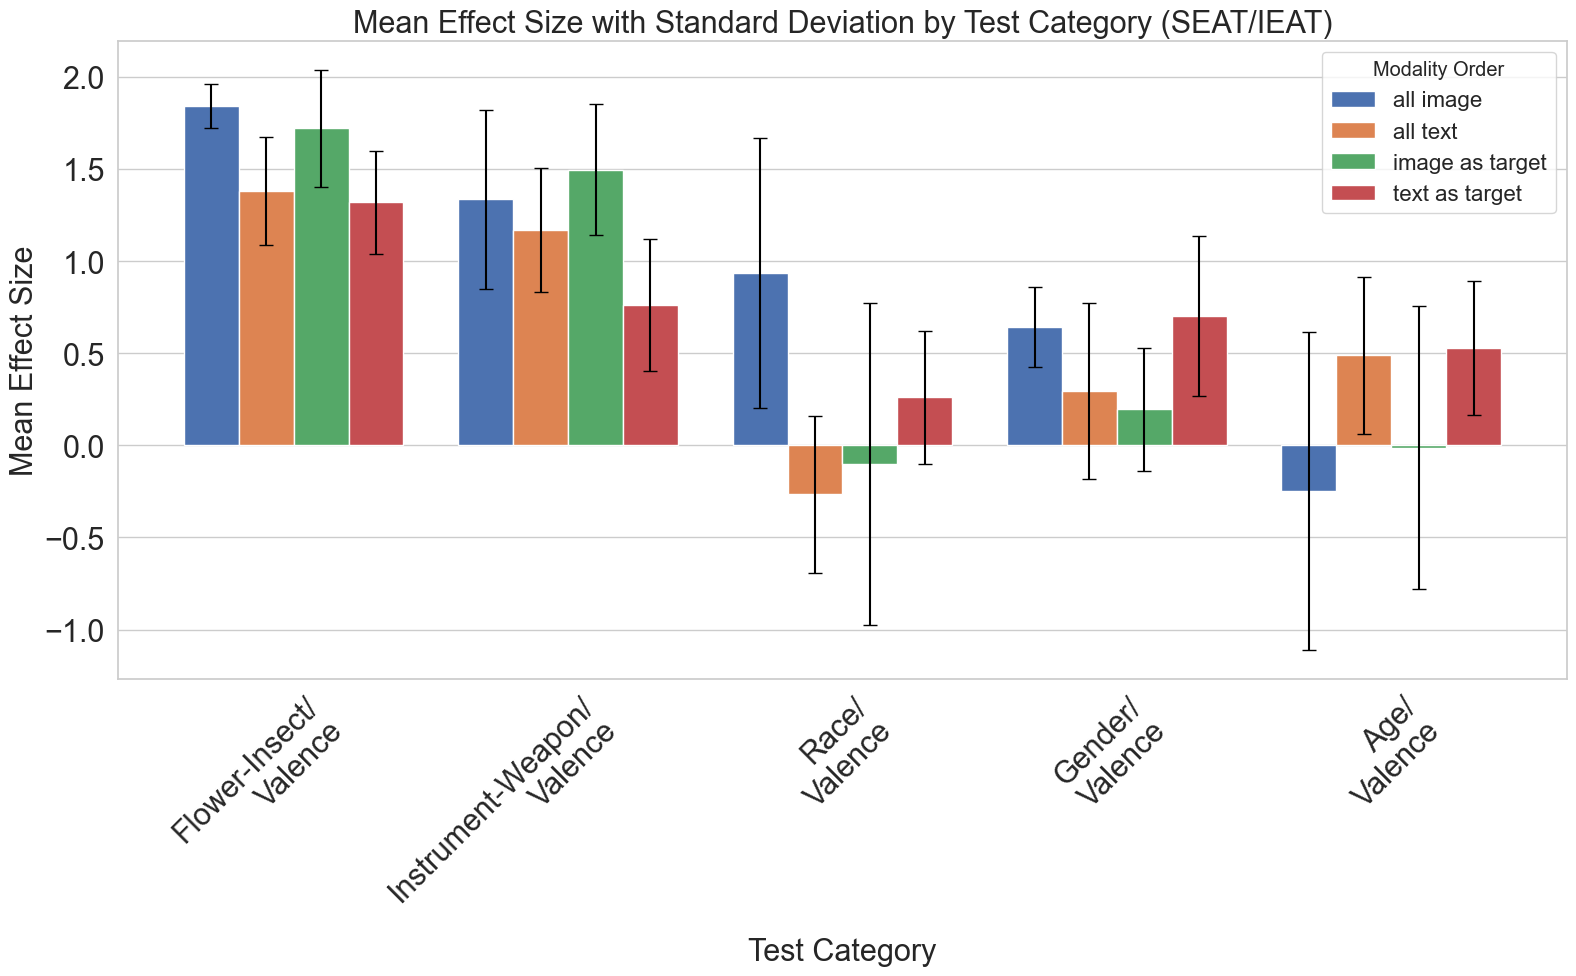

Aggregated data (means and std):
               Image Test           order  effect_size_mean  effect_size_std
              Age/Valence       all image         -0.247280         0.861328
              Age/Valence        all text          0.489890         0.426005
              Age/Valence image as target         -0.011852         0.769915
              Age/Valence  text as target          0.528304         0.362014
           Gender/Valence       all image          0.643003         0.218885
           Gender/Valence        all text          0.296105         0.476238
           Gender/Valence image as target          0.196032         0.334294
           Gender/Valence  text as target          0.701400         0.435733
    Insect-Flower/Valence       all image          1.842158         0.118616
    Insect-Flower/Valence        all text          1.381038         0.294083
    Insect-Flower/Valence image as target          1.722503         0.318453
    Insect-Flower/Valence  text as target  

In [83]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean_std_barplot(df, title, filename):
    """
    Create a grouped bar plot of mean effect sizes with standard deviation error bars.
    """

    # 1. Check for required columns
    required_cols = ['Image Test', 'order', 'effect_size']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("Required columns are missing from the DataFrame.")

    # 2. Define the desired order of categories
    category_order = [
        'Insect-Flower/Valence',
        'Instrument-Weapon/Valence',
        'Race/Valence',
        'Gender/Valence',
        'Age/Valence'
    ]

    # Filter to only these categories
    df = df[df['Image Test'].isin(category_order)]

    # 3. Aggregate: compute mean and std
    means = df.groupby(['Image Test', 'order'])['effect_size'].mean().reset_index()
    stds  = df.groupby(['Image Test', 'order'])['effect_size'].std().reset_index()

    # Merge into a single DataFrame
    aggregated_data = means.merge(
        stds, 
        on=['Image Test','order'],
        suffixes=('_mean','_std')
    )

    # 4. Create the bar plot of means
    plt.figure(figsize=(16, 10))
    sns.set(style="whitegrid", font_scale=1.2)

    # Barplot using the precomputed means as "y", with darker colors
    ax = sns.barplot(
        data=aggregated_data,
        x='Image Test',
        y='effect_size_mean',
        hue='order',
        order=category_order,
        alpha=1.0,  # Full opacity
        saturation=1.0  # Full color saturation
    )
    # Create two-line category labels
    shortened_categories = []
    for cat in category_order:
        parts = cat.split('/')
        if len(parts) > 1:
            if parts[0] == 'Insect-Flower':
                shortened_categories.append('Flower-Insect/\nValence')
            else:
                shortened_categories.append(f"{parts[0]}/\nValence")
        else:
            shortened_categories.append(cat)

    # 5. Manually add the std error bars
    #    We'll replicate how seaborn spaces groups when there's a 'hue' variable
    hue_levels = aggregated_data['order'].unique()
    num_hue_levels = len(hue_levels)
    bar_width = 0.8  # default total bar width for each x-category
    # Each hue bar gets a fraction of that width
    hue_width = bar_width / num_hue_levels

    # Precompute x positions for categories
    x_positions = np.arange(len(category_order))

    for i, hue_val in enumerate(hue_levels):
        subset = aggregated_data[aggregated_data['order'] == hue_val].copy()
        # Reindex so that subset is in the correct category order
        subset = subset.set_index('Image Test').reindex(category_order).reset_index()

        # For grouped bars, each hue is offset from the "center" x by some fraction
        offset = -0.5 * bar_width + (i + 0.5) * hue_width

        # Calculate the actual x-coordinates for each category in this hue
        x_coords = x_positions + offset

        # Plot error bars
        plt.errorbar(
            x=x_coords,
            y=subset['effect_size_mean'],
            yerr=subset['effect_size_std'],  # standard deviation
            fmt='none',
            ecolor='black',
            capsize=5,
            zorder=10
        )

    # 6. Final formatting
    plt.title(title, fontsize=22)
    plt.xlabel('Test Category', fontsize=22)
    plt.ylabel('Mean Effect Size', fontsize=22)
    plt.xticks(x_positions + 0.2, shortened_categories, rotation=45, ha='right', fontsize=22)  # Added 0.1 offset to x-tick positions
    plt.yticks(fontsize=22)
    plt.tight_layout()
    plt.legend(title='Modality Order', fontsize=16)

    # 7. Save and show
    plt.savefig('../results/plots/aggregate_effect_size_old_camera_ready.pdf', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()

    # 8. Print raw data
    print("Aggregated data (means and std):")
    print(aggregated_data.to_string(index=False))


# Example usage
plot_mean_std_barplot(
    cross_modal_old_df,
    "Mean Effect Size with Standard Deviation by Test Category (SEAT/IEAT)",
    "old_effect_size_barplot_sd_camera_ready.pdf"
)


In [15]:
df = cross_modal_nrc_oasis_df

In [7]:
# Convert categorical variables to 'category' dtype
categorical_vars = ['architecture', 'pretraining_dataset', 'order']
for var in categorical_vars:
    df[var] = df[var].astype('category')


In [11]:
import statsmodels.formula.api as smf

# Define the mixed effects model formula
# Fixed effects: log_params, architecture, pretraining_dataset, log_dataset_size
# Random effects: random intercepts for 'order'
model_formula = "effect_size ~ log_params + architecture + pretraining_dataset + log_dataset_size"

# Instantiate the mixed effects model
mixed_model = smf.mixedlm(
    formula=model_formula,
    data=df,
    groups=df["order"],  # Grouping variable for random effects
    re_formula="1"       # Random intercepts
)

# Fit the model
mixed_model_fit = mixed_model.fit()

# Display the summary of the model
print(mixed_model_fit.summary())




/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                                     Mixed Linear Model Regression Results
Model:                              MixedLM                   Dependent Variable:                   effect_size
No. Observations:                   2882                      Method:                               REML       
No. Groups:                         4                         Scale:                                0.5401     
Min. group size:                    524                       Log-Likelihood:                       -3161.2749 
Max. group size:                    917                       Converged:                            No         
Mean group size:                    720.5                                                                      
---------------------------------------------------------------------------------------------------------------
                                                     Coef.    Std.Err.    z    P>|z|     [0.025       0.975]   
-----------------------------

/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.623371
  warnings.warn(msg, ConvergenceWarning)
/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, Con

In [19]:
cross_modal_nrc_oasis_df.columns

Index(['Image Test', 'Text Test', 'image_target_dir', 'image_target_1',
       'image_target_2', 'image_attribute_dir', 'image_attribute_1',
       'image_attribute_2', 'text_file', 'text_target_1', 'text_target_2',
       'text_attribute_1', 'text_attribute_2', 'order', 'nt', 'naa', 'nab',
       'model', 'pvalue', 'effect_size', 'npermutations', 'architecture',
       'other_info', 'vision_model_family', 'pretraining_dataset',
       'pretraining_samples_seen', 'model_name', 'epochs', 'samples_per_epoch',
       'fine_tuned', 'params', 'flops', 'pretraining_dataset_size',
       'model_source', 'vtab', 'vtab+', 'race_maxskew_eq_opp',
       'race_ndkl_eq_opp', 'gender_maxskew_eq_opp', 'gender_ndkl_eq_opp',
       'total_flops', 'log_dataset_size', 'log_params', 'architecture_family',
       'dataset_family'],
      dtype='object')

In [7]:
# a. Simplify 'architecture' into 'architecture_family'
df =cross_modal_nrc_oasis_df.copy()
# def categorize_architecture(arch):
#     if any(keyword in arch for keyword in ['ViT', 'EVA', 'roberta', 'nllb']):
#         return 'Transformers'
#     elif 'RN' in arch:
#         return 'RN'
#     elif 'convnext' in arch:
#         return 'convnext'
#     else:
#         return arch  # Unique categories

def categorize_architecture(arch):
    # **CoCa Models**
    if arch.startswith('coca'):
        return 'CoCa Models'
    # **EVA Models**
    elif arch.startswith('EVA'):
        return 'EVA Models'
    # **NLLB-CLIP Models**
    elif arch.startswith('nllb'):
        return 'NLLB-CLIP Models'
    # **Hybrid Models with Text Encoders**
    elif 'roberta' in arch or 'xlm-roberta' in arch:
        return 'Hybrid Models with Text Encoders'
    # **ConvNeXt Models**
    elif 'convnext' in arch:
        return 'ConvNeXt Models'
    # **ResNet (RN) Models**
    elif arch.startswith('RN'):
        return 'ResNet Models'
    # **Vision Transformer (ViT) Models**
    # **Specialized ViT Models**
    elif 'SO400M' in arch or 'SigLIP' in arch or 'plus' in arch:
        return 'Specialized ViT Models'
    # **Vision Transformer (ViT) Models**
    elif arch.startswith('ViT'):
        return 'ViT Models'
    # **Other or Unique Models**
    else:
        return 'Other Models'


df['architecture_family'] = df['architecture'].apply(categorize_architecture)

# Merge rare architecture families into 'Other'
architecture_counts = df['architecture_family'].value_counts()
rare_architectures = architecture_counts[architecture_counts < 30].index
df['architecture_family'] = df['architecture_family'].replace(rare_architectures, 'Other')

# b. Simplify 'pretraining_dataset' into 'dataset_family'
dataset_keywords = [
    'laion', 'metaclip', 'openai_wit', 'datacomp', 'webli', 
    'webli_multilingual', 'commonpool', 'laion_aesthetic',
    'mscoco_finetuned_laion2b', 'commonpool_xl_clip_filtered',
    'commonpool_xl_laion_filtered', 'dfn', 'yfcc15m', 'cc12m', 'merged2b'
]

def categorize_dataset(ds):
    for keyword in dataset_keywords:
        if keyword in ds:
            return keyword
    return ds  # Unique categories

df['dataset_family'] = df['pretraining_dataset'].apply(categorize_dataset)

# Merge rare dataset families into 'Other'
dataset_counts = df['dataset_family'].value_counts()
# rare_datasets = dataset_counts[dataset_counts < 30].index
# df['dataset_family'] = df['dataset_family'].replace(rare_datasets, 'Other')

# c. Inspect new categories
print("Architecture Families:")
print(df['architecture_family'].value_counts())

print("\nDataset Families:")
print(df['dataset_family'].value_counts())

Architecture Families:
architecture_family
ViT Models                          2236
Specialized ViT Models               260
ConvNeXt Models                      234
ResNet Models                        208
EVA Models                           182
NLLB-CLIP Models                     104
CoCa Models                          104
Hybrid Models with Text Encoders      78
Name: count, dtype: int64

Dataset Families:
dataset_family
laion         1508
commonpool     520
datacomp       338
openai_wit     286
webli          286
metaclip       182
dfn            104
merged2b       104
yfcc15m         52
cc12m           26
Name: count, dtype: int64


In [9]:
import pandas as pd
import numpy as np

df_2 = df.copy()

# Simplify categorical variables as per previous steps
# (Ensure you've already created 'architecture_family' and 'dataset_family' as per your previous steps)

# Create a combined grouping variable by concatenating 'order' and 'Image Test'
df['group'] = df['order'].astype(str) + '_' + df['Image Test'].astype(str)

# Convert the new 'group' column to categorical
df['group'] = df['group'].astype('category')

# Inspect the new grouping variable
print("Combined Grouping Variable (group) Distribution:")
print(df['group'].value_counts())

Combined Grouping Variable (group) Distribution:
group
text as target_Race/Valence                  393
all text_Race/Valence                        393
text as target_Gender/Valence                262
all text_Gender/Valence                      262
image as target_Gender/Valence               131
text as target_Instrument-Weapon/Valence     131
text as target_Insect-Flower/Valence         131
text as target_Age/Valence                   131
image as target_Race/Valence                 131
image as target_Instrument-Weapon/Valence    131
image as target_Insect-Flower/Valence        131
all image_Age/Valence                        131
all image_Gender/Valence                     131
all text_Instrument-Weapon/Valence           131
all text_Insect-Flower/Valence               131
all text_Age/Valence                         131
all image_Race/Valence                       131
all image_Instrument-Weapon/Valence          131
all image_Insect-Flower/Valence              131
image as targe

# Camera Ready

In [10]:
#Assume df
import statsmodels.formula.api as smf

# 2. Data Cleaning and Feature Engineering
key_columns = ['effect_size', 'params', 'pretraining_dataset_size', 
               'architecture_family', 'dataset_family', 'order']
# Drop rows with missing values in these columns
df_clean = df.dropna(subset=key_columns).copy()

# Reset index after dropping rows
df_clean.reset_index(drop=True, inplace=True)

# Create log-transformed variables
df_clean['log_params'] = np.log(df_clean['params'])
df_clean['log_dataset_size'] = np.log(df_clean['pretraining_dataset_size'])

# Convert categorical variables to 'category' dtype
categorical_vars = ['architecture_family', 'dataset_family', 'group']
for var in categorical_vars:
    df_clean[var] = df_clean[var].astype('category')

# Scale continuous variables to improve numerical stability
scaler = StandardScaler()
df_clean[['log_params', 'log_dataset_size']] = scaler.fit_transform(
    df_clean[['log_params', 'log_dataset_size']]
)
# 3. Define and Fit Mixed Effects Model
model_formula = "effect_size ~ log_params + architecture_family + dataset_family + log_dataset_size"
mixed_model = smf.mixedlm(
    formula=model_formula,
    data=df_clean,
    groups=df_clean["group"],
    re_formula="~ log_params + log_dataset_size"
)

# Fit the model
try:
    mixed_model_fit = mixed_model.fit(reml=True, method='lbfgs', maxiter=1000)
    print(mixed_model_fit.summary())
except Exception as e:
    print(f"Model fitting failed: {e}")


                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              effect_size
No. Observations:              3406                 Method:                          REML       
No. Groups:                    20                   Scale:                           0.1953     
Min. group size:               131                  Log-Likelihood:                  -2173.3255 
Max. group size:               393                  Converged:                       Yes        
Mean group size:               170.3                                                            
------------------------------------------------------------------------------------------------
                                                        Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                               0.26

/Users/kshitishghate/miniforge3/envs/clip_bias/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [11]:
fixed_effects = mixed_model_fit.summary().tables[1]
fixed_effects

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.262,0.190,1.378,0.168,-0.110,0.634
architecture_family[T.ConvNeXt Models],0.072,0.053,1.362,0.173,-0.031,0.174
architecture_family[T.EVA Models],0.077,0.071,1.086,0.278,-0.062,0.216
architecture_family[T.Hybrid Models with Text Encoders],0.093,0.066,1.407,0.159,-0.037,0.223
architecture_family[T.NLLB-CLIP Models],0.158,0.077,2.047,0.041,0.007,0.309
architecture_family[T.ResNet Models],0.072,0.073,0.990,0.322,-0.071,0.215
architecture_family[T.Specialized ViT Models],0.136,0.079,1.713,0.087,-0.020,0.292
architecture_family[T.ViT Models],0.062,0.046,1.339,0.180,-0.029,0.152
dataset_family[T.commonpool],0.399,0.106,3.757,0.000,0.191,0.608
dataset_family[T.datacomp],0.360,0.108,3.347,0.001,0.149,0.571


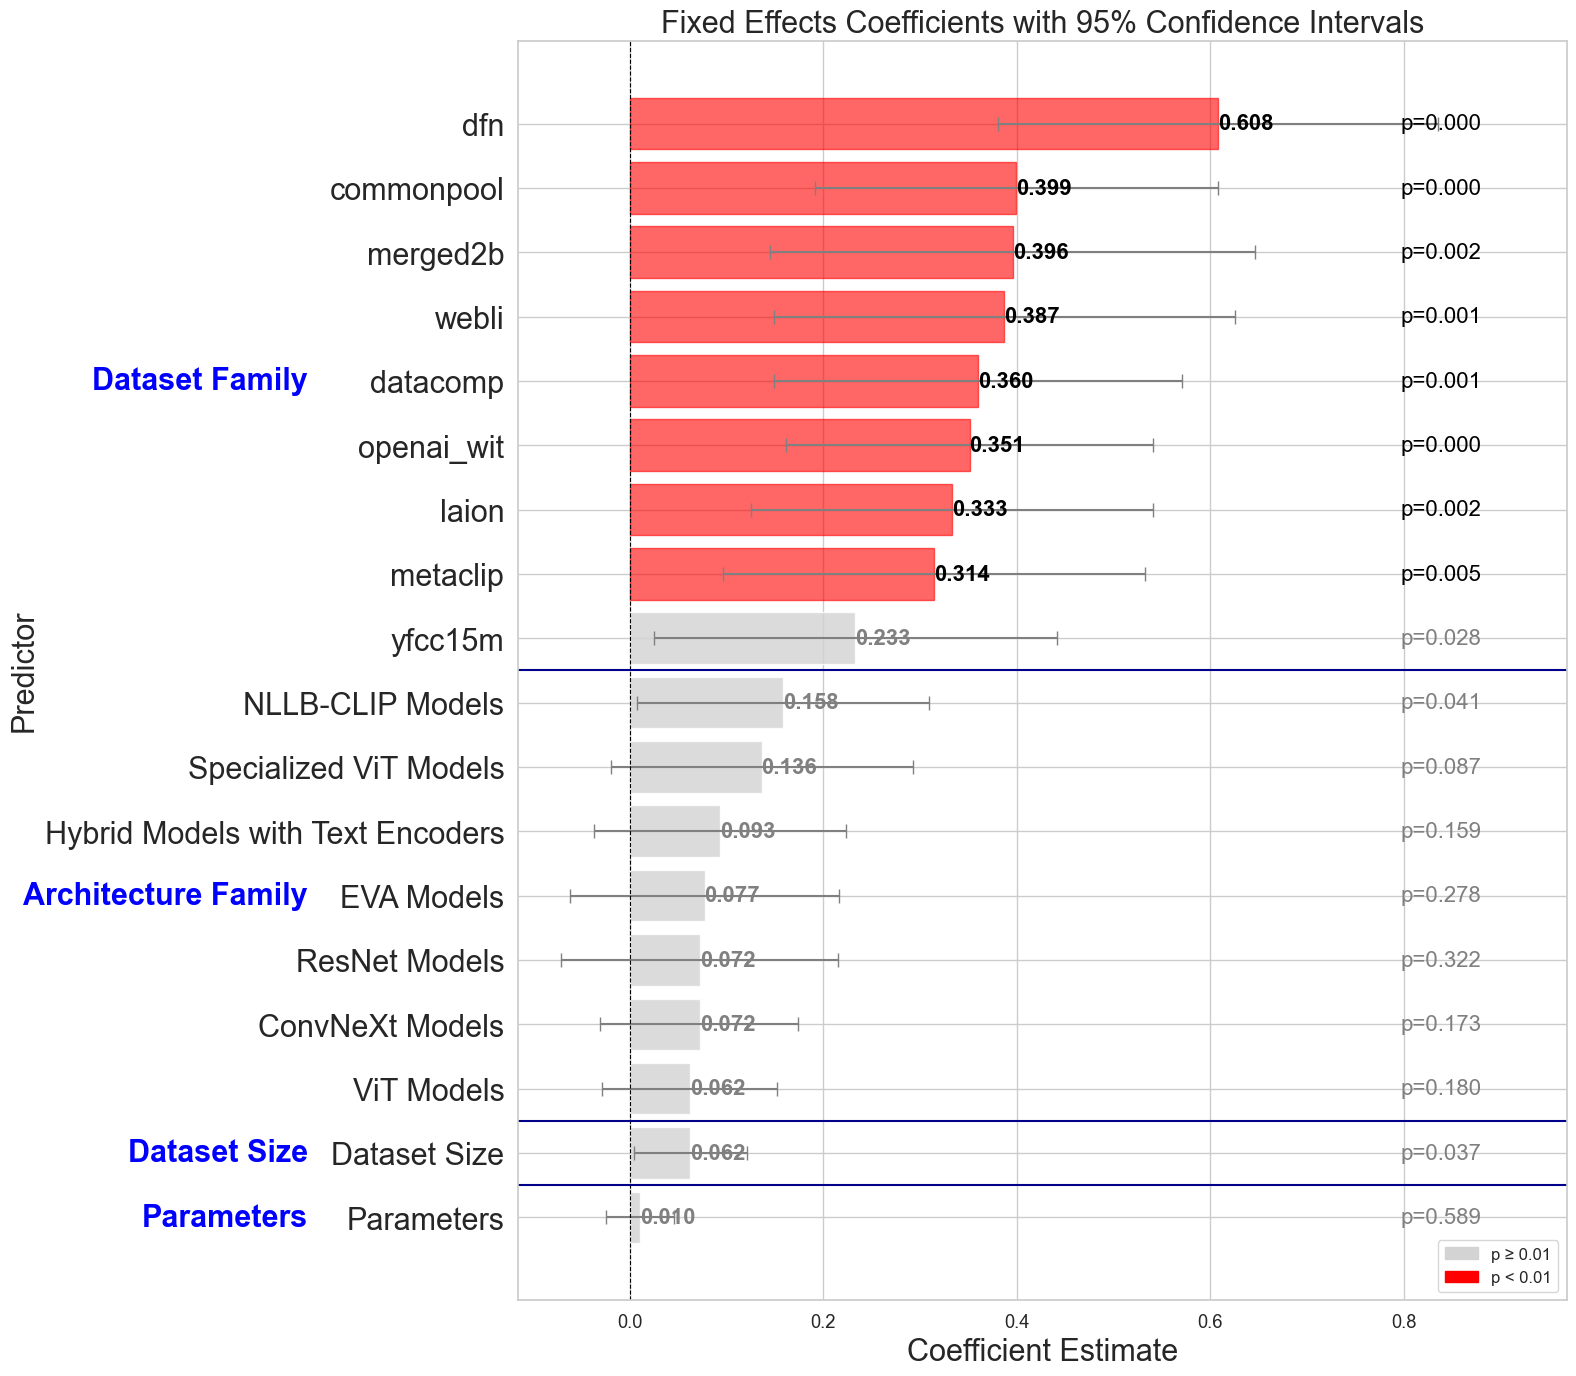

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'mixed_model_fit' is your fitted MixedLM model
# Extract fixed effects summary
fixed_effects = mixed_model_fit.summary().tables[1]
fixed_effects = fixed_effects.iloc[1:]  # Skip header
fixed_effects = pd.DataFrame(fixed_effects, columns=['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]'])


# Function to safely convert to float
def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

# Apply safe conversion to float for numeric columns
numeric_columns = ['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']
for col in numeric_columns:
    fixed_effects[col] = fixed_effects[col].apply(safe_float)

# Remove rows with NaN values resulting from conversion
fixed_effects = fixed_effects.dropna()

# Determine significance
fixed_effects['Significant'] = fixed_effects['P>|z|'] < 0.01

# Sort by coefficient magnitude
fixed_effects_sorted = fixed_effects.sort_values('Coef.', ascending=True)


# Set the plot size
plt.figure(figsize=(16, 14))

# Define groups and their order (reversed)
groups = {
    'Dataset Family': [col for col in fixed_effects_sorted.index if col.startswith('dataset_family')],
    'Architecture Family': [col for col in fixed_effects_sorted.index if col.startswith('architecture_family')],
    'Dataset Size': ['log_dataset_size'],
    'Parameters': ['log_params']
}

# Sort within groups and create a new sorted index
sorted_index = []
for group_items in groups.values():
    sorted_index.extend(sorted(group_items, key=lambda x: fixed_effects_sorted.loc[x, 'Coef.'], reverse=True))

fixed_effects_sorted = fixed_effects_sorted.loc[sorted_index]

# Clean up y-axis labels
def clean_label(label):
    label = label.replace('dataset_family', '')
    label = label.replace('architecture_family', '')
    label = label.replace('[T.', '')
    label = label.replace(']', '')
    label = label.replace('log_dataset_size', 'Dataset Size')
    label = label.replace('log_params', 'Parameters')
    return label.strip()

fixed_effects_sorted.index = fixed_effects_sorted.index.map(clean_label)

# Reverse the order of y-axis labels
fixed_effects_sorted = fixed_effects_sorted.iloc[::-1]

# Create a horizontal bar plot
bars = plt.barh(y=fixed_effects_sorted.index, 
                width=fixed_effects_sorted['Coef.'], 
                xerr=[fixed_effects_sorted['Coef.'] - fixed_effects_sorted['[0.025'], 
                      fixed_effects_sorted['0.975]'] - fixed_effects_sorted['Coef.']], 
                capsize=5, color='lightgray', ecolor='gray', alpha=0.8)

# Highlight significant coefficients
for i, (_, row) in enumerate(fixed_effects_sorted.iterrows()):
    if row['Significant']:
        bars[i].set_color('red')
        bars[i].set_alpha(0.6)

# Add a vertical line at zero
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Customize the plot
plt.xlabel('Coefficient Estimate', fontsize=22)
plt.ylabel('Predictor', fontsize=22)
plt.title('Fixed Effects Coefficients with 95% Confidence Intervals', fontsize=22)
plt.tick_params(axis='y', which='major', labelsize=22)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Create a legend
import matplotlib.patches as mpatches
non_sign_patch = mpatches.Patch(color='lightgray', label='p ≥ 0.01')
sign_patch = mpatches.Patch(color='red', label='p < 0.01')
plt.legend(handles=[non_sign_patch, sign_patch], loc='lower right', fontsize=12)

# Add coefficient values as text
for i, (_, row) in enumerate(fixed_effects_sorted.iterrows()):
    color = 'black' if row['Significant'] else 'gray'
    plt.text(row['Coef.'], i, f"{row['Coef.']:.3f}", 
             va='center', ha='left' if row['Coef.'] >= 0 else 'right',
             fontsize=16, color=color, fontweight='bold')

# Add p-values as text
for i, (_, row) in enumerate(fixed_effects_sorted.iterrows()):
    color = 'black' if row['Significant'] else 'gray'
    plt.text(plt.xlim()[1], i, f"p={row['P>|z|']:.3f}", 
             va='center', ha='right', fontsize=16, color=color)

# Adjust x-axis to make room for p-values
plt.xlim(plt.xlim()[0], plt.xlim()[1] * 1.1)

# Add darker and thicker lines between groups (changed color to dark blue)
current_pos = len(fixed_effects_sorted)
for group_name, group_items in groups.items():
    group_size = len([item for item in group_items if clean_label(item) in fixed_effects_sorted.index])
    if current_pos < len(fixed_effects_sorted):
        plt.axhline(y=current_pos - 0.5, color='darkblue', linestyle='-', linewidth=1.5)
    current_pos -= group_size

# Add group labels
current_pos = len(fixed_effects_sorted)
for group_name, group_items in groups.items():
    group_size = len([item for item in group_items if clean_label(item) in fixed_effects_sorted.index])
    if group_size > 0:
        plt.text(-0.2, (current_pos - group_size / 2) - 0.5, group_name, 
                 va='center', ha='right', fontsize=22, fontweight='bold', color='blue', 
                 transform=plt.gca().get_yaxis_transform())
    current_pos -= group_size

# Save the plot as PDF
plt.savefig('../results/plots/upstream_figure_10pc_sig_camera_ready.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


# Correlation Analysis

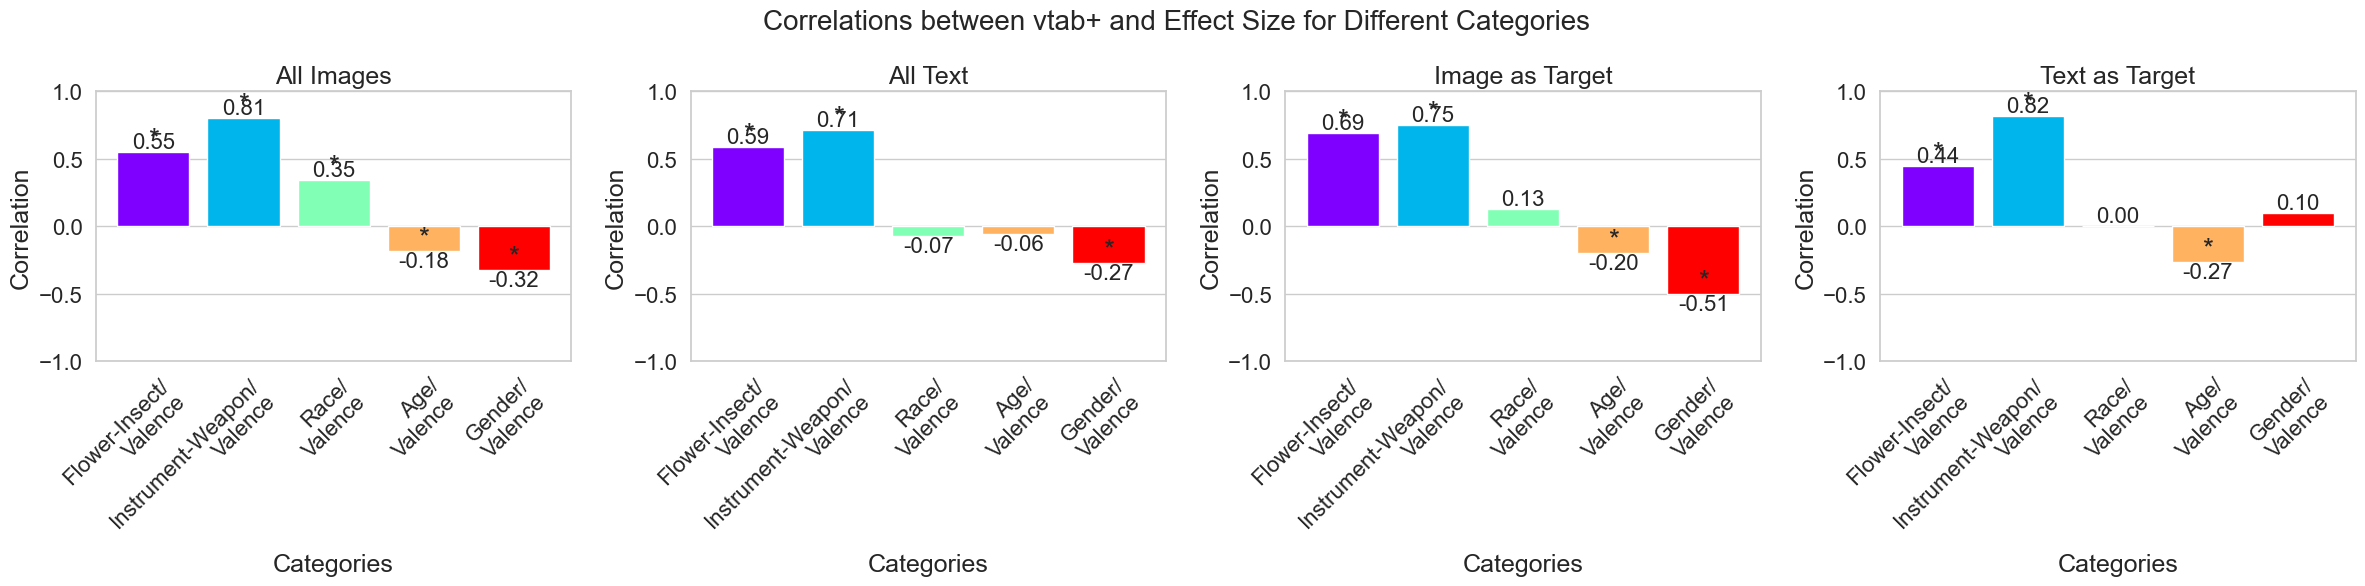

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

df = cross_modal_nrc_oasis_df.copy()

# Recalculate correlations with significance
def calculate_correlation_and_significance(x, y):
    correlation, p_value = stats.pearsonr(x, y)
    return correlation, p_value

# Get unique categories from 'Image Test' column
categories = df['Image Test'].unique()

# Move last category to second position (index 1)
categories = np.array(list(categories[:-1]) + [categories[-1]])
categories = np.array([categories[0]] + [categories[-1]] + list(categories[1:-1]))

# Prepare data for plotting
image_as_target_corr = []
text_as_target_corr = []
all_images_corr = []
all_text_corr = []
image_as_target_sig = []
text_as_target_sig = []
all_images_sig = []
all_text_sig = []

for cat in categories:
    # Image as target
    cat_data = df[(df['Image Test'] == cat) & (df['order'] == 'image as target')]
    corr, p_val = calculate_correlation_and_significance(cat_data['effect_size'], cat_data['vtab+'])
    image_as_target_corr.append(corr)
    image_as_target_sig.append(p_val < 0.05)
    
    # Text as target
    cat_data = df[(df['Image Test'] == cat) & (df['order'] == 'text as target')]
    corr, p_val = calculate_correlation_and_significance(cat_data['effect_size'], cat_data['vtab+'])
    text_as_target_corr.append(corr)
    text_as_target_sig.append(p_val < 0.05)
    
    # All images
    cat_data = df[(df['Image Test'] == cat) & (df['order'] == 'all image')]
    corr, p_val = calculate_correlation_and_significance(cat_data['effect_size'], cat_data['vtab+'])
    all_images_corr.append(corr)
    all_images_sig.append(p_val < 0.05)
    
    # All text
    cat_data = df[(df['Image Test'] == cat) & (df['order'] == 'all text')]
    corr, p_val = calculate_correlation_and_significance(cat_data['effect_size'], cat_data['vtab+'])
    all_text_corr.append(corr)
    all_text_sig.append(p_val < 0.05)

# Set up the plot
plt.rcParams.update({'font.size': 14})  # Increase overall font size
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Correlations between vtab+ and Effect Size for Different Categories', fontsize=20)

# Generate a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))

# Find the global min and max for y-axis
all_corrs = all_images_corr + all_text_corr + image_as_target_corr + text_as_target_corr
y_min, y_max = min(all_corrs), max(all_corrs)
y_max = 1
y_min = -1

# Function to plot bars with significance markers and coefficient numbers
def plot_bars_with_significance(ax, categories, correlations, significances, colors, title):
    # Create two-line category labels
    # Create two-line category labels
    shortened_categories = []
    for cat in categories:
        parts = cat.split('/')
        if len(parts) > 1:
            if parts[0] == 'Insect-Flower':
                shortened_categories.append('Flower-Insect/\nValence')
            else:
                shortened_categories.append(f"{parts[0]}/\nValence")
        else:
            shortened_categories.append(cat)
    
    bars = ax.bar(range(len(categories)), correlations, color=colors)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Categories', fontsize=18)
    ax.set_ylabel('Correlation', fontsize=18)
    ax.set_xticks([x + 0.4 for x in range(len(categories))])  # Shift x-ticks to the right
    ax.set_xticklabels(shortened_categories, rotation=45, ha='right', fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylim(y_min, y_max)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    
    # Add significance markers and coefficient numbers
    for i, (corr, sig) in enumerate(zip(correlations, significances)):
        ax.text(i, corr, f'{corr:.2f}', ha='center', va='bottom' if corr >= 0 else 'top', fontsize=16)
        if sig:
            ax.text(i, corr, '*', ha='center', va='bottom', fontsize=20)

# Plot for All Images
plot_bars_with_significance(axs[0], categories, all_images_corr, all_images_sig, colors, 'All Images')

# Plot for All Text
plot_bars_with_significance(axs[1], categories, all_text_corr, all_text_sig, colors, 'All Text')

# Plot for Image as Target
plot_bars_with_significance(axs[2], categories, image_as_target_corr, image_as_target_sig, colors, 'Image as Target')

# Plot for Text as Target
plot_bars_with_significance(axs[3], categories, text_as_target_corr, text_as_target_sig, colors, 'Text as Target')

plt.tight_layout()
plt.savefig('../results/plots/correlation_plot_camera_ready.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [87]:
pip install git+https://github.com/acl-org/aclpubcheck

  Cloning https://github.com/acl-org/aclpubcheck to /private/var/folders/fl/1gq7191x4gs4lszf8szpl6jm0000gn/T/pip-req-build-dzemd2lf
  Running command git clone --filter=blob:none --quiet https://github.com/acl-org/aclpubcheck /private/var/folders/fl/1gq7191x4gs4lszf8szpl6jm0000gn/T/pip-req-build-dzemd2lf
  Resolved https://github.com/acl-org/aclpubcheck to commit 81e1fc830c3c1dc4c57b5a0293d39987c0f169cd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 52.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━

In [93]:
!aclpubcheck --paper_type long ../NAACL/CLIP_Bias_NAACL_ARR_2025_Camera_Ready.pdf

Checking ../NAACL/CLIP_Bias_NAACL_ARR_2025_Camera_Ready.pdf
All Clear!


In [90]:
!pwd

/Users/kshitishghate/Library/CloudStorage/OneDrive-Personal/My Stuff/Academia/Aylin_Mona_Summer/language_vision_bias/experiments
